## Import packages

In [3]:
import glam
import pandas as pd
import numpy as np
import os.path

In [4]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [5]:
np.random.seed(23) # from random.org

In [6]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [7]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [9]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [10]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [11]:
def z_score1_nopart(data_all, z_score_var):
    z_matrix=[]

    Choicedata = data_all 
    pX_A= pd.to_numeric(Choicedata[z_score_var])    
    pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    z_matrix= pX_zA.values
           
    return z_matrix

In [12]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

## Define some parameters for the simulations


In [13]:
# Parameters for the simulations
boundary=1
error_weight=0.05
# Using median values for the parameters extracted from GLAM fit for all 33 participants (binned case, for this case)
gamma = -0.57
tau = 1.62
v = 0.000049
s = 0.00797
t0 = 0
parameters = [v , gamma, s, tau, t0]
## error_range given by the reaction time values for an individual participant
rt_min = 1500
rt_max = 5000
error_range = (rt_min, rt_max)

n_repeats = 1

----------------------------------------------------------------------------
# 1. Simulations : |DEvidence| ~ Confidence? Hurdles check

In the following points I will check if DEvidence (the absolute difference between the accumulators for left and right items), as calculated from GLAM, overcomes the hurdles reported in Moran et al. (2015) as typical empirical patterns observed in the choice-confidence paradigm. 

I defined different pairs of values for the two options and I kept constant the gaze ratio for left and right item (50% of time in each item) 


## 1.1. Negative relationship between confidence and difficulty?

### Create a matrix with controlled differences in value and in gaze ratios

In [11]:
## DEFINE PARAMETERS
# Using median values for the parameters (binned case, for now)
gamma = -0.57
tau = 1.62
v = 0.000049
s = 0.00797
t0 = 0
parameters = [v , gamma, s, tau, t0]
## error_range given by the reaction time values for an individual participant
rt_min = 1500
rt_max = 5000
error_range = (rt_min, rt_max)

n_repeats = 1

#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
# replicate the values three times to have bigger sample (remember we have a noise component that makes the results different despite the same pair)
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

# Simulate trials 
Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

In [11]:
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):    
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][0] -value_tests[i][1]))
    absDG.append(abs(gaze_tests[i][0] -gaze_tests[i][1]))

Pearson's r = 0.313 p =  0.001


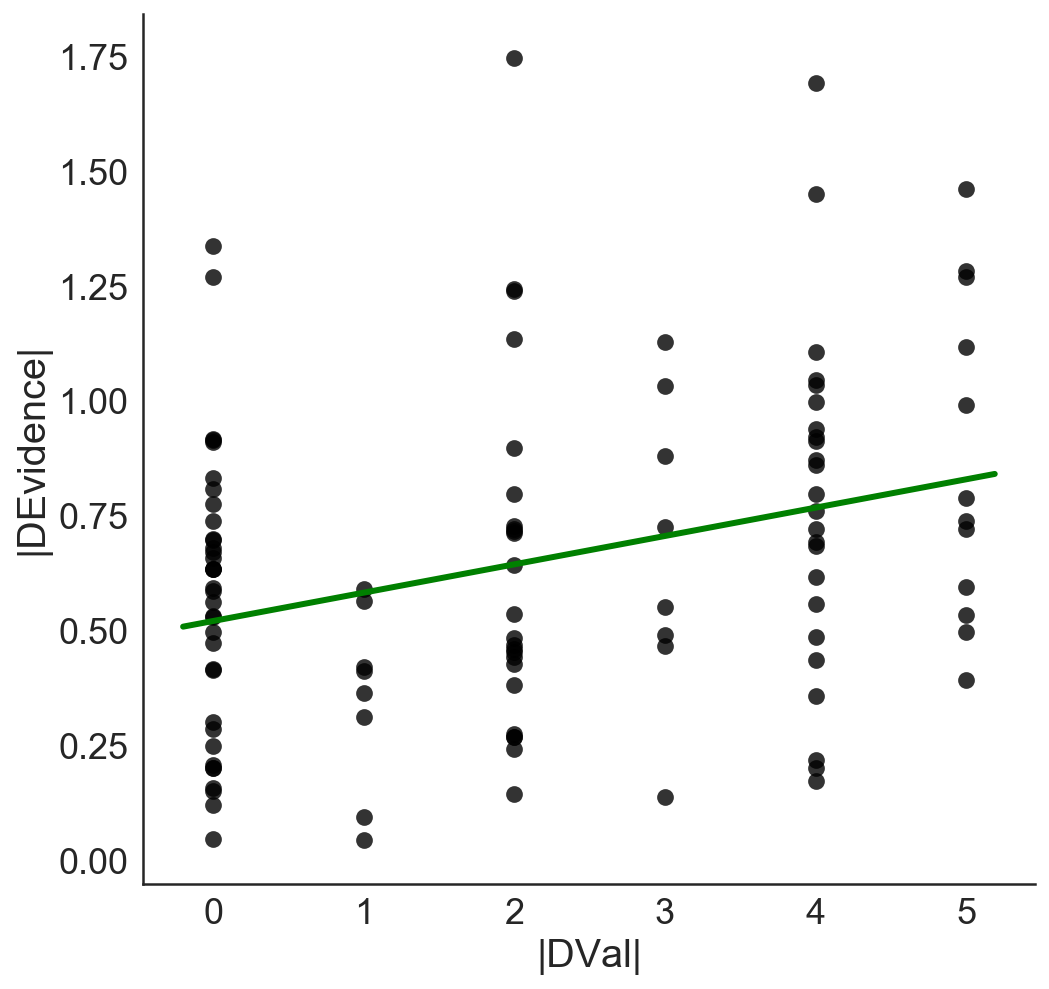

In [12]:
df = pd.DataFrame({'DVal':absDV, 'DGazw':absDG, 'RT':rts,'DEv':Dev_a})
correl_plot(df,'DVal', "|DVal|",'DEv','|DEvidence|')

The more difficult the choice (lower |DVal|) |DEvidence| decreases

## 1.2. Negative relationship between confidence and RT? During free response tasks

In [17]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests,value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.2, 0.8], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):    
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

Pearson's r = -0.262 p =  0.0


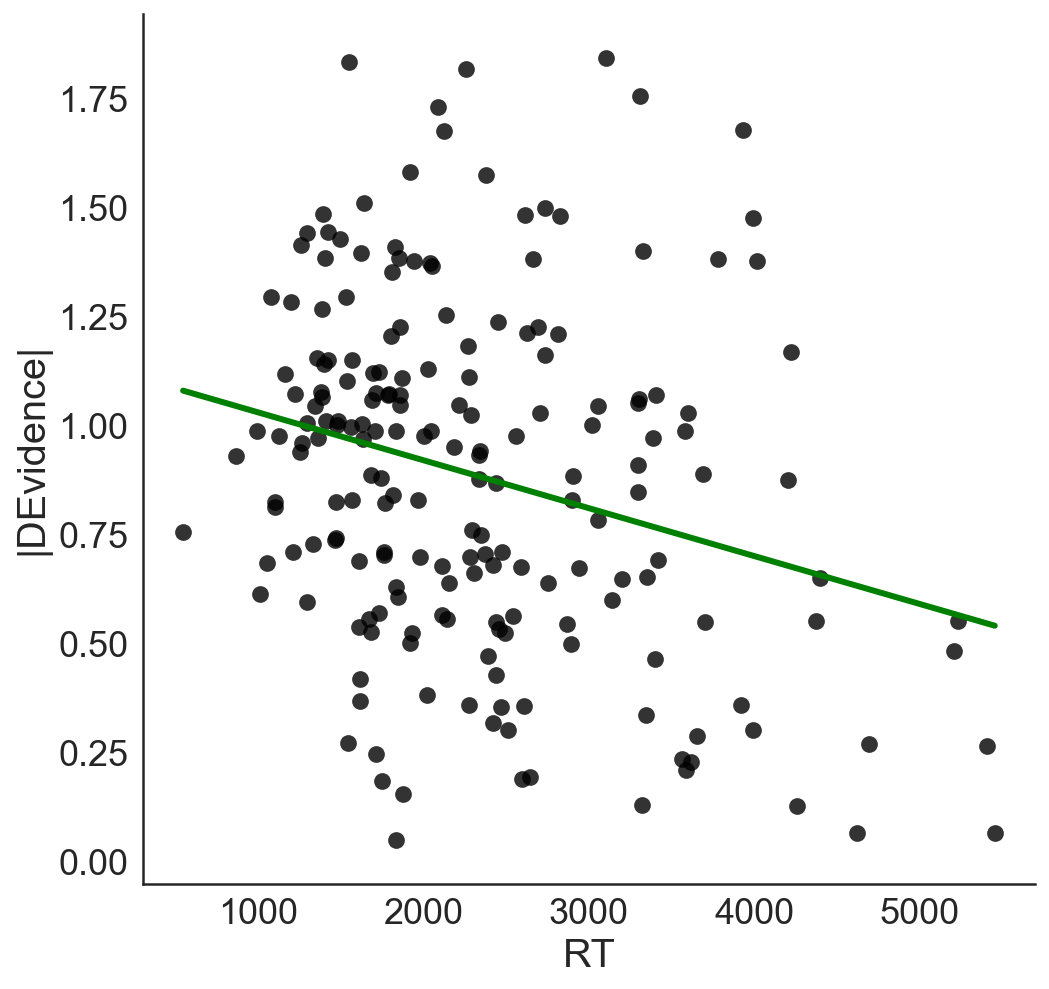

In [18]:
#Plotting   
df = pd.DataFrame({'DVal':absDV, 'DGazw':absDG, 'RT':rts,'DEv':Dev_a})
correl_plot(df,'RT', "RT",'DEv','|DEvidence|')

The faster the free response time (lower RT) higher is the |DEvidence|

## 1.3. Positive relationship between confidence and RT? During controlled response tasks

In [19]:
#DEFINE THE VALUES TO TEST
n_repeats = 1

value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

In [20]:
#generate vector with the reaction times (controlled) and difference in evidence.
# Since it is controlled reaction time, we consider how would it behaves if we give less time that required to answer freely, which would be before the min reaction time.
controlRT = []
controlDEv = []

for p in range(len(evi_seq_0)):
    for s in range(100,rt_min,100):
         if s<len(evi_seq_1[p][0]):
            controlDEv.append(abs(evi_seq_1[p][0][s] - evi_seq_0[p][0][s])) 
            controlRT.append(s)  

Pearson's r = 0.426 p =  0.0


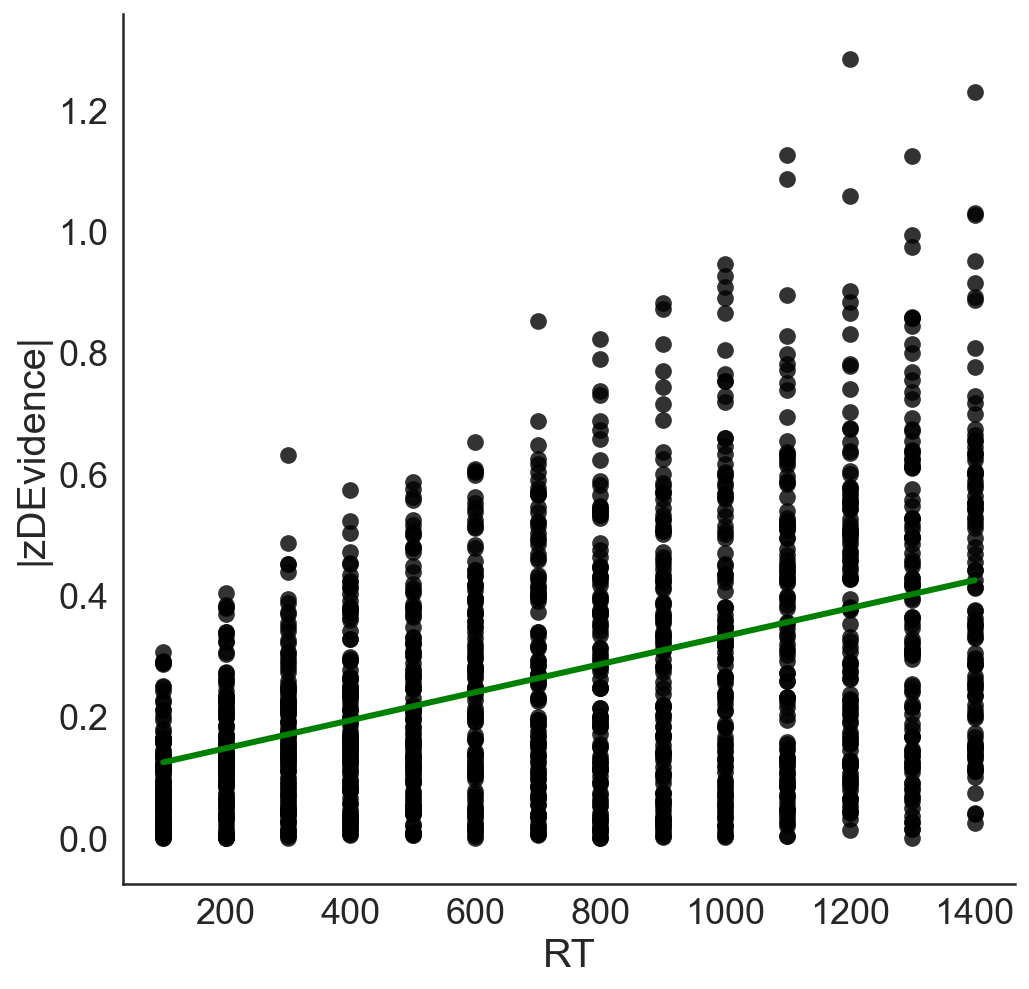

In [21]:
#Plotting   
df = pd.DataFrame({'RT':controlRT,'DEv':controlDEv})
correl_plot(df,'RT', "RT",'DEv','|zDEvidence|')

I simulated controlled response as the case when the simulation has less time than required to give a free response. Since I set a free response range of 1500-5000 [ms] I consider that controlled responses will be given before we reach the minimum time observed for free response.
We observe that |zDEvidence| increases with RT in this case

## 1.4. Resolution of confidence (Choice correctness and confidence are positively correlated)

We increase the number of datapoints in the following simulations (to have correct estimates of resolution of confidence)

In [22]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

correct =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (choices[i] == 1 and value_tests[i][1]>value_tests[i][0]) or (choices[i] == 0 and value_tests[i][1]<value_tests[i][0]):
        correct.append(1)
    else:
        correct.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

In [23]:
#Plotting   
df = pd.DataFrame({'Correct':correct,'DEv':Dev_a,'DVal':absDV})

Pearson's r = 0.435 p =  0.0


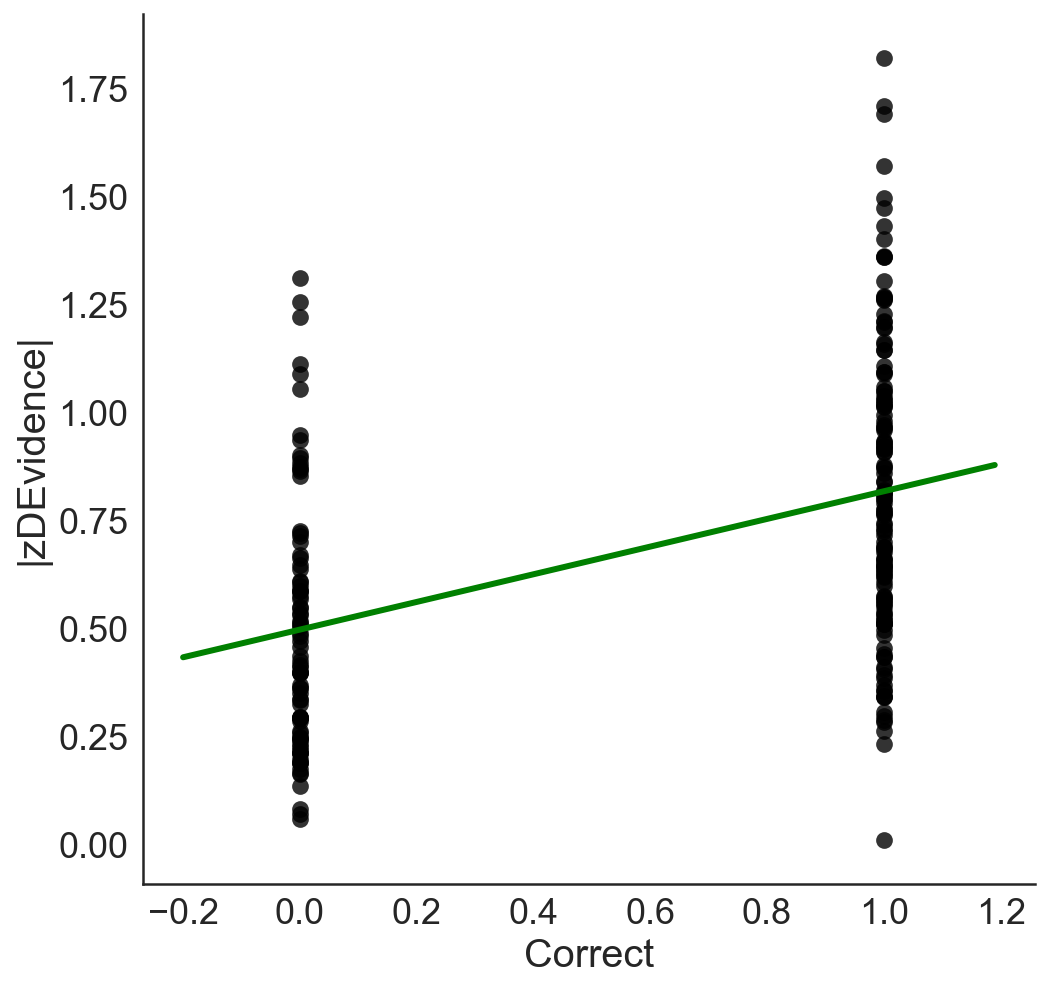

In [24]:
correl_plot(df,'Correct',"Correct",'DEv','|zDEvidence|')

In [25]:
%%R -i df
d <- df

BIC: 261.3728
Call:  glm(formula = Correct ~ DEv, family = binomial(link = "logit"), 
    data = d)

Coefficients:
(Intercept)          DEv  
     -1.637        3.252  

Degrees of Freedom: 223 Total (i.e. Null);  222 Residual
Null Deviance:	    299.3 
Residual Deviance: 250.5 	AIC: 254.5


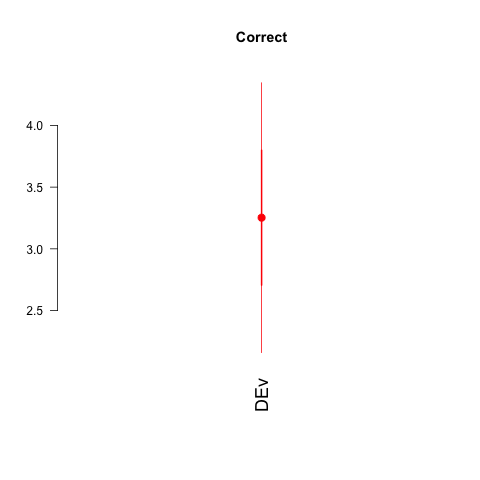

In [26]:
%%R    
title_plot = "Correct"
ModelChoice_1 <- glm(Correct ~ DEv  , data= d,family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

From linear regression, there is a positive effect of |DEVidence| over the outcome of the choice (Correct response)

## 1.5. Increased resolution in confidence with time pressure on choice
When choice is made under conditions that stress speed rather than accuracy, resolution of confidence increases

In [13]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

In [12]:
Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

KeyboardInterrupt: 

In [28]:
## generate correct vector
correct_answer =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (value_tests[i][1]>value_tests[i][0]):
        correct_answer.append(1)
    else:
        correct_answer.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))


#generate vector with the reaction times (controlled) and difference in evidence.
# Since it is controlled reaction time, we consider how would it behaves if we give less time that required to answer freely, which would be before the min reaction time.
controlRT = []
controlDEv = []
controlCorrect = []

for p in range(len(evi_seq_0)):
    for s in range(100,rt_min,50):
         if s<len(evi_seq_1[p][0]):    
            controlDEv.append(abs(evi_seq_1[p][0][s] - evi_seq_0[p][0][s])) 
            controlRT.append(s)  
            if ((evi_seq_1[p][0][s] > evi_seq_0[p][0][s]) and (correct_answer[p]==1)) or (evi_seq_1[p][0][s] < evi_seq_0[p][0][s]) and (correct_answer[p]==0) :
                    controlCorrect.append(1)    
            else:
                    controlCorrect.append(0)
            
            

Pearson's r = 0.376 p =  0.0


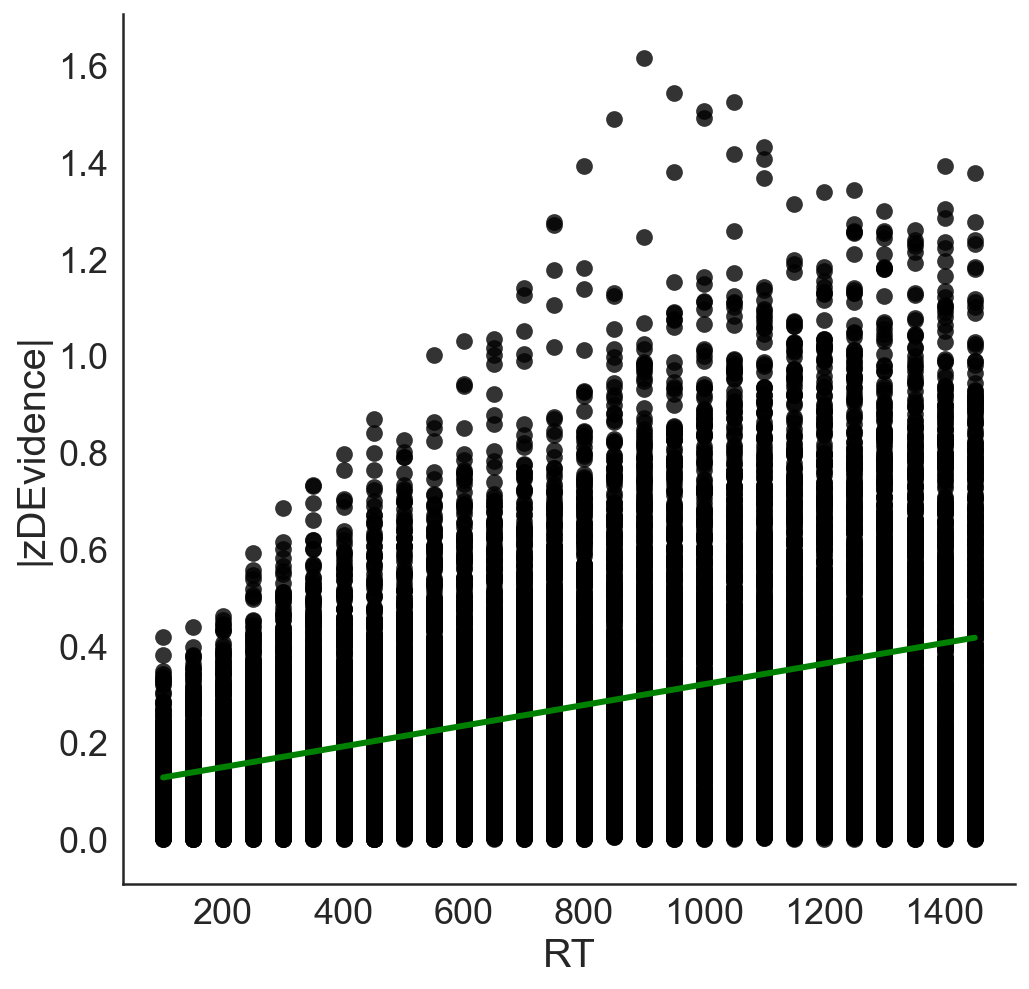

In [29]:
#Plotting   
df = pd.DataFrame({'RT':controlRT,'DEv':controlDEv,'Correct':controlCorrect})
correl_plot(df,'RT', "RT",'DEv','|zDEvidence|')

In [30]:
stressResolution = []
stressRT =[]
for s in  (df['RT'].unique()):
    stressRT.append(s)
    Selected_data = df.loc[df['RT'] == s]    
    logit = sm.Logit(Selected_data['Correct'],Selected_data['DEv'])
    result = logit.fit(disp=0)
    slope_curr = result.params.values[0]
    stressResolution.append(slope_curr)

Pearson's r = -0.961 p =  0.0


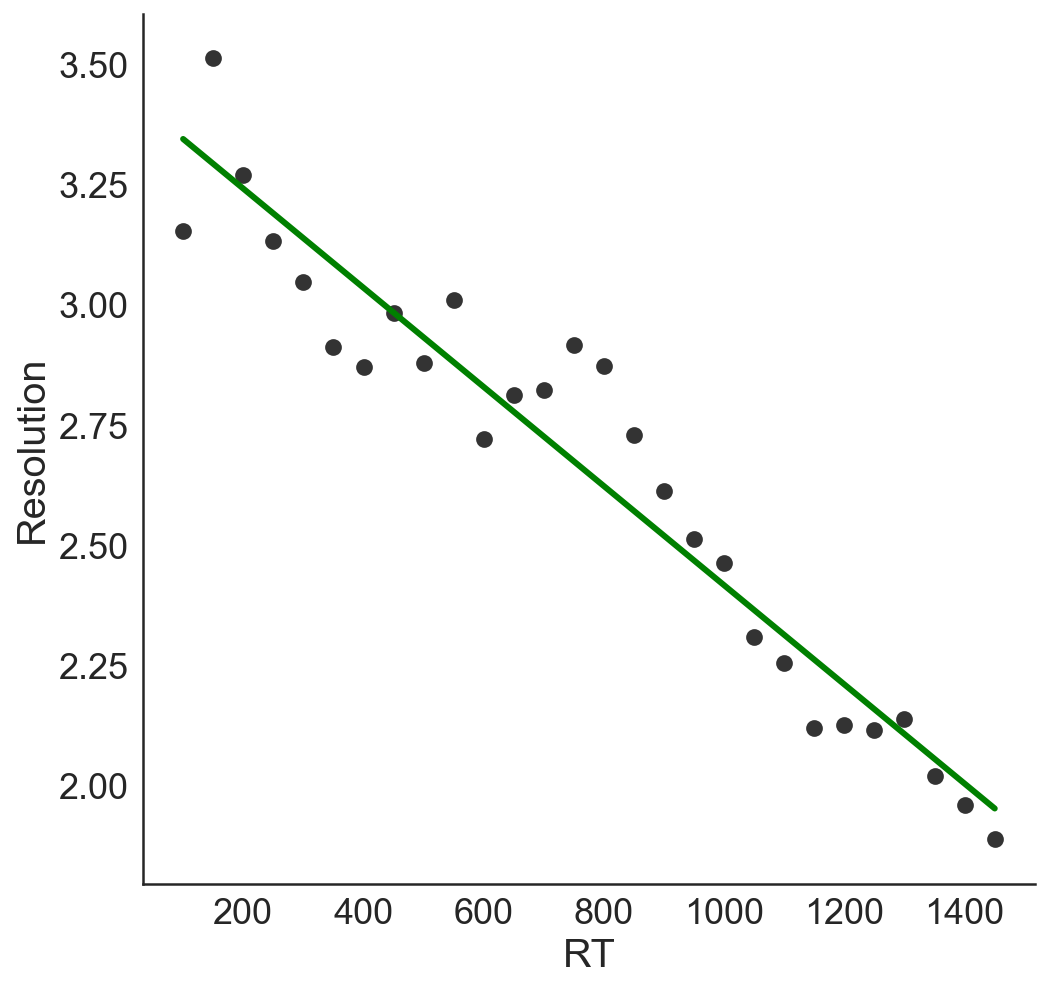

In [31]:
df2 = pd.DataFrame({'RT':stressRT,'Resolution':stressResolution})
correl_plot(df2,'RT', "RT",'Resolution','Resolution')

The more "stressed" the response (lower RT) the better the resolution (resolution measured as the slope of a logistic regression between Correct and AbsDEvidence). 

** This result seems to be less robust since it appears to dependend on the particular simulation, and sometimes is expressed only a negative trend between resolution and RT **

## 1.6. Difficulty and choice accuracy interaction on confidence

 "As the difficulty level increases confidence decreases for correct choices and increases for error choices. Thus, the overall resolution decreases".
 
Or alternatively, if difficulty decreases (DVal increases) confidence increases for correct choices and decreases for errors.

In [32]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

correct =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
for i in range(len(value_tests)):
    if (choices[i] == 1 and value_tests[i][1]>value_tests[i][0]) or (choices[i] == 0 and value_tests[i][1]<value_tests[i][0]):
        correct.append(1)
    else:
        correct.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] -value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] -gaze_tests[i][0]))
 

In [33]:
#Plotting   
df = pd.DataFrame({'Correct':correct,'DEv':Dev_a,'DVal':absDV})

In [34]:
%%R -i df
d <- df

BIC: 240.1069
Call:  glm(formula = DEv ~ Correct + Correct:DVal, data = d)

Coefficients:
 (Intercept)       Correct  Correct:DVal  
     0.48692       0.04635       0.06210  

Degrees of Freedom: 447 Total (i.e. Null);  445 Residual
Null Deviance:	    51 
Residual Deviance: 42.45 	AIC: 223.7


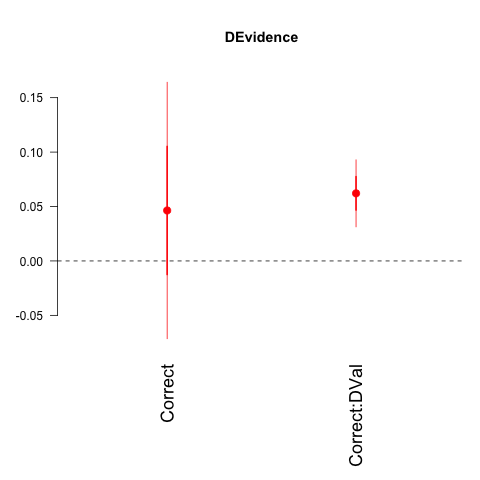

In [35]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(DEv ~ Correct  + Correct:DVal  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

We observe a positive interaction between Correct and DVal which means that when |DVal| increases (less difficulty) and we have a correct answer, confidence also increases.

## - I did not considered the hurdles related to RT2:
 RT2 correlations
 
 Difficulty and choice accuracy interaction on RT2

---------------------------------------------------------------------------
# 2 . Does the relationship between TotVal and DEvidence replicates the relationship we found with Total Value and Confidence?

## Using simiulated GLAM data 

In [49]:
#DEFINE THE VALUES TO TEST
value_tests = np.array([[5 ,0],[4,0],[3,0], [2,0], [1,0], [0,0],[1 ,5],[2,4],[3,3], [4,2], [5,1],[0,5],[5 ,1],[4,2],[3,3], [2,4], [1,5],[0,5],[0,4],[0,3],[0,2],[0,1],[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests), axis=0)
value_tests = np.concatenate((value_tests, value_tests,value_tests,value_tests), axis=0)

gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)

Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

correct =[]
value_0 =[]
value_1 = []
gaze_0 = []
gaze_1 = []
absDV = []
absDG = []
TotV = []
for i in range(len(value_tests)):
    if (choices[i] == 1 and value_tests[i][1]>value_tests[i][0]) or (choices[i] == 0 and value_tests[i][1]<value_tests[i][0]):
        correct.append(1)
    else:
        correct.append(0)
    value_0.append(value_tests[i][0])
    value_1.append(value_tests[i][1])
    gaze_0.append(gaze_tests[i][0])
    gaze_1.append(gaze_tests[i][1])
    absDV.append(abs(value_tests[i][1] - value_tests[i][0]))
    TotV.append(abs(value_tests[i][1] + value_tests[i][0]))
    absDG.append(abs(gaze_tests[i][1] - gaze_tests[i][0]))
#Plotting   
df = pd.DataFrame({'TotV':TotV,'DEv':Dev_a,'DVal':absDV,'RTsim':rts})
 

BIC: 680.7954
Call:  glm(formula = DEv ~ TotV + DVal + TotV:DVal, data = d)

Coefficients:
(Intercept)         TotV         DVal    TotV:DVal  
   0.555876    -0.001032     0.074028    -0.003616  

Degrees of Freedom: 895 Total (i.e. Null);  892 Residual
Null Deviance:	    117 
Residual Deviance: 108 	AIC: 656.8


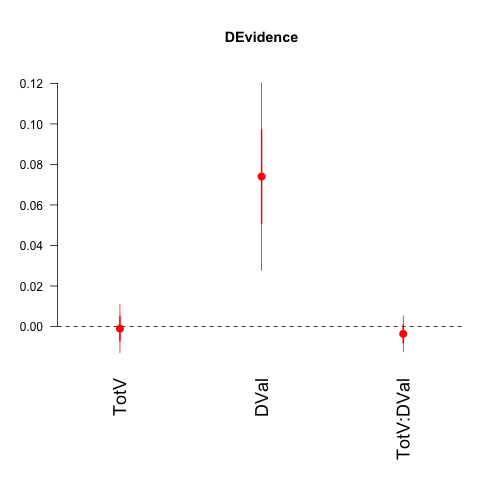

In [50]:
%%R -i df
d <- df
title_plot = "DEvidence"
ModelChoice_1 <- glm(DEv ~ TotV + DVal + TotV:DVal  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

But remember that in this case we are assuming equal attentional component to both items

BIC: 651.4339
Call:  glm(formula = DEv ~ DVal + TotV + RTsim, data = d)

Coefficients:
(Intercept)         DVal         TotV        RTsim  
  7.406e-01    5.036e-02   -5.640e-03   -5.567e-05  

Degrees of Freedom: 895 Total (i.e. Null);  892 Residual
Null Deviance:	    117 
Residual Deviance: 104.5 	AIC: 627.4


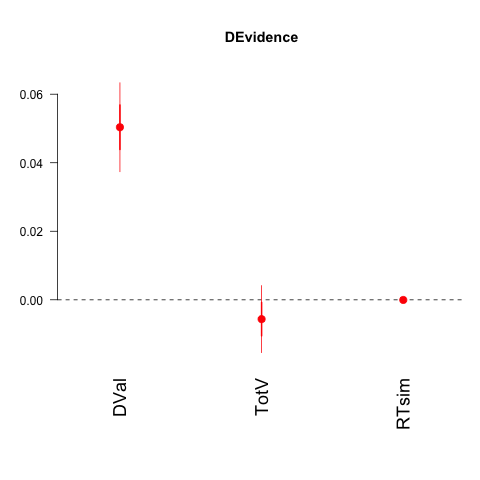

In [51]:
%%R -i df
d <- df
title_plot = "DEvidence"
ModelChoice_1 <- glm(DEv ~ DVal + TotV + RTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

----------------------------------------------------------------------------------------------------------
# 3. Simulations of DEvidence using participant's parameters and comparison with reported confidence

## Load data and GLAM structure 
Used binned data for simulation.

In [11]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [12]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

## Load parameter estimates for participants

## Like condition

Use the parameter estimates from GLAM fit for Like, Binned data

In [13]:
sufix = '_Like_NoBin_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [14]:
params_part

,v_sd,v_mu,gamma_mu,tau_mu,t0,b,tau_sd,SNR,p_error,tau,gamma_sd,gamma,SNR_sd,v,s,SNR_mu
0,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,151.23,0.05,3.74,0.38,-0.11,35.54,0.000047,0.007843,164.29
1,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.71,0.05,4.30,0.38,0.29,35.54,0.000072,0.010344,164.29
2,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,141.48,0.05,2.59,0.38,-0.00,35.54,0.000058,0.008574,164.29
3,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,157.60,0.05,4.65,0.38,-0.10,35.54,0.000043,0.007178,164.29
4,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,96.58,0.05,4.22,0.38,-0.37,35.54,0.000080,0.007063,164.29
5,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,113.65,0.05,2.80,0.38,0.15,35.54,0.000059,0.008615,164.29
6,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,163.65,0.05,3.55,0.38,-0.00,35.54,0.000069,0.010656,164.29
7,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,150.49,0.05,3.29,0.38,-0.08,35.54,0.000045,0.007405,164.29
8,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,175.26,0.05,1.24,0.38,-0.71,35.54,0.000053,0.009622,164.29
9,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.66,0.05,4.77,0.38,-0.08,35.54,0.000048,0.007104,164.29


### Run drift simulations for selected values and parameters

In [15]:
if os.path.exists(str('results/simulations/drift_simulations_like_31_part.csv')):  
   
        data_all = pd.read_csv("results/simulations/drift_simulations_like_31_part.csv")


In [16]:
n_repeats = 4

In [17]:
if not os.path.exists(str('results/simulations/drift_simulations_like_31_part.csv')):  
    # We will assume that every single pair in test will have a gaze_test pair assigned. Therefore
    # len(value_tests) = len(gaze_tests) 
          
    # Using median participant parameters for testing drift
    
    # repeat for all the 'i' participants
    #
    
    AbsDEvid = []
    RT_sim = []
    
    #for i in ([0, 1, 2, 3]):    
    for i in (data['subject'].unique()):    
        PartData = data.loc[data['subject'] == i]
        value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
        gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
    
        gamma = params_part['gamma'][i]
        tau = params_part['tau'][i]
        v = params_part['v'][i]
        s = params_part['s'][i]
        t0 = 0
        parameters = [v , gamma, s, tau, t0]
        ## error_range given by the reaction time values for an individual participant
        rt_min = glam_full.data['rt'][glam_full.data['subject'] == i].values.min()
        rt_max = glam_full.data['rt'][glam_full.data['subject'] == i].values.max()
        error_range = (rt_min, rt_max)
    
        Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)
    
        for  j in range(len(Dev_a)):    
            AbsDEvid.append(Dev_a[j])
            RT_sim.append(rts[j])
        
        print ("subj " + str(i))

        #np.save(str('results/simulations/drift_simulations_31_part.npy'), data_all)
#else:
   # data_all = np.load('results/simulations/drift_simulations_31_part.npy')   

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30


In [18]:
if not  os.path.exists(str('results/simulations/drift_simulations_like_31_part.csv')):  
        data_all["AbsDEv"] = AbsDEvid
        data_all["RTsim"] = RT_sim    
        data_all.to_csv("results/simulations/drift_simulations_like_31_part.csv")
        


## Dislike condition

Use the parameter estimates from GLAM fit for Like, Binned data

In [24]:
sufix = '_Dislike_NoBin_Dislike_NUTS_Inv_31'
glam_full = glam.GLAM(data2)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [25]:
params_part

,gamma_mu,gamma,p_error,gamma_sd,tau_sd,v_mu,b,SNR_sd,v_sd,tau_mu,tau,t0,v,s,SNR_mu,SNR
0,-0.09,0.53,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000039,0.005929,186.55,175.47
1,-0.09,0.73,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.18,0.0,0.000050,0.010297,186.55,200.96
2,-0.09,0.97,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,0.93,0.0,0.000042,0.007670,186.55,159.54
3,-0.09,-0.05,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,2.92,0.0,0.000037,0.007801,186.55,178.00
4,-0.09,0.18,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.10,0.0,0.000050,0.009849,186.55,186.73
5,-0.09,0.27,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.45,0.0,0.000047,0.008528,186.55,173.28
6,-0.09,0.21,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,1.81,0.0,0.000055,0.009641,186.55,145.49
7,-0.09,-0.09,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.79,0.0,0.000042,0.007573,186.55,159.34
8,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,3.15,0.0,0.000047,0.008367,186.55,160.79
9,-0.09,-0.67,0.05,0.48,1.01,0.000044,1.0,35.83,0.000011,2.85,4.68,0.0,0.000052,0.007714,186.55,124.54


### Run drift simulations for selected values and parameters

In [26]:
if os.path.exists(str('results/simulations/drift_simulations_dislike_inv_31_part.csv')):  
        data_all2 = pd.read_csv("results/simulations/drift_simulations_dislike_inv_31_part.csv")

In [27]:
n_repeats = 4

In [28]:
if not os.path.exists(str('results/simulations/drift_simulations_dislike_inv_31_part.csv')):  
    # We will assume that every single pair in test will have a gaze_test pair assigned. Therefore
    # len(value_tests) = len(gaze_tests) 
          
    # Using median participant parameters for testing drift
    
    # repeat for all the 'i' participants
    
    AbsDEvid2 = []
    RT_sim2 = []
    
    #for i in ([0, 1, 2, 3]):    
    for i in (data['subject'].unique()):    
        PartData = data2.loc[data2['subject'] == i]
        value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
        gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
    
        gamma = params_part['gamma'][i]
        tau = params_part['tau'][i]
        v = params_part['v'][i]
        s = params_part['s'][i]
        t0 = 0
        parameters = [v , gamma, s, tau, t0]
        ## error_range given by the reaction time values for an individual participant
        rt_min = glam_full.data['rt'][glam_full.data['subject'] == i].values.min()
        rt_max = glam_full.data['rt'][glam_full.data['subject'] == i].values.max()
        error_range = (rt_min, rt_max)
    
        Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)
    
        for  j in range(len(Dev_a)):    
            AbsDEvid2.append(Dev_a[j])
            RT_sim2.append(rts[j])
        
        print ("subj " + str(i))

        #np.save(str('results/simulations/drift_simulations_31_part.npy'), data_all)
#else:
   # data_all = np.load('results/simulations/drift_simulations_31_part.npy')   

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30


In [29]:
if not  os.path.exists(str('results/simulations/drift_simulations_dislike_inv_31_part.csv')):  
        data_all2["AbsDEv"] = AbsDEvid2
        data_all2["RTsim"] = RT_sim2   
        data_all2.to_csv("results/simulations/drift_simulations_dislike_inv_31_part.csv")

## Calculate z-score and correlation between DEvidence and Confidence

In [30]:
zs1 = z_score1(data_all,'Part','AbsDEv')
zs2 = z_score1(data_all,'Part','RTsim')

data_all["zAbsDEv"] = zs1
data_all["zRTsim"] = zs2

Pearson's r = 0.13 p =  0.0


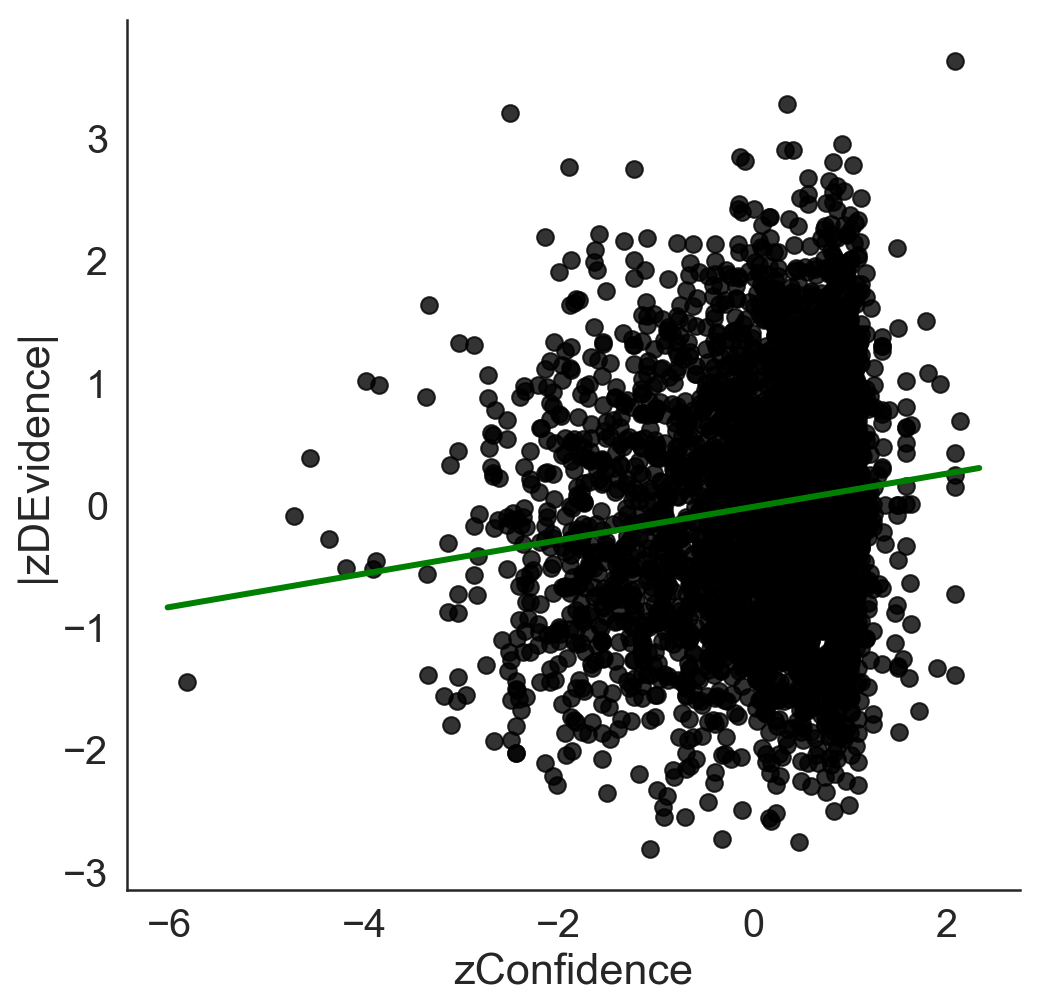

In [31]:
correl_plot(data_all,'zConf', "zConfidence",'zAbsDEv','|zDEvidence|')

* We z-scored the absolute values, that's why we obtain |zDEvidence| include some negative values

In [32]:
data_all.columns

Index(['Part', 'TrialN', 'PairID', 'LItem', 'LVal', 'RItem', 'RVal', 'Choice',
       'RT', 'Conf', 'ConfRT', 'BlockCond', 'DDT', 'LDwellTime', 'RDwellTime',
       'GSF', 'LastFixat', 'DVal', 'zDVal', 'AbsDVal', 'zAbsDVal', 'zConf',
       'zRT', 'DFam', 'LFam', 'RFam', 'TotFam', 'TotVal', 'ChosenFam',
       'UnchosenFam', 'ChosenVal', 'UnchosenVal', 'Correct', 'LValConfBDM',
       'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam', 'zTotFam',
       'zTotVal', 'zChosenVal', 'zUnchosenVal', 'zChosenFam', 'zUnchosenFam',
       'zGSF', 'zDDT', 'zAbsDDT', 'zAbsDFam', 'zLVal', 'zRVal', 'zLFam',
       'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM', 'zRFamConfBDM',
       'ConfSplit', 'GSFSplit', 'DDTSplit', 'AbsDEv', 'RTsim', 'zAbsDEv',
       'zRTsim'],
      dtype='object')

In [33]:
%%R -i data_all
d <- data_all

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 10131.65
Call:  glm(formula = zConf ~ zAbsDEv, data = d)

Coefficients:
(Intercept)      zAbsDEv  
    0.09625      0.12306  

Degrees of Freedom: 3719 Total (i.e. Null);  3718 Residual
Null Deviance:	    3353 
Residual Deviance: 3296 	AIC: 10110


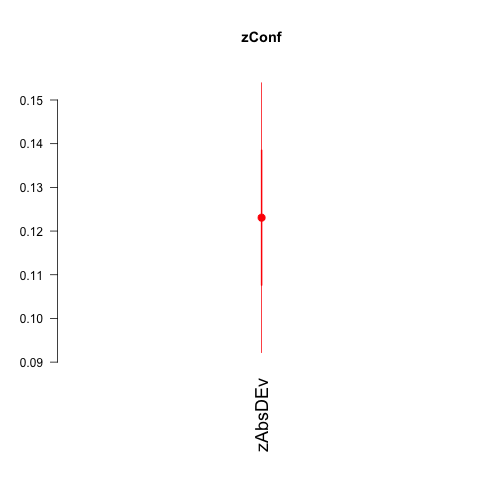

In [34]:
%%R    
title_plot = "zConf"
ModelChoice_1 <- glm(zConf ~ zAbsDEv  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

## Check if simulations replicate Total Value result

BIC: 9587.924
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
  0.0005615    0.2214820    0.1029489   -0.3442364  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    3720 
Residual Deviance: 2835 	AIC: 9557


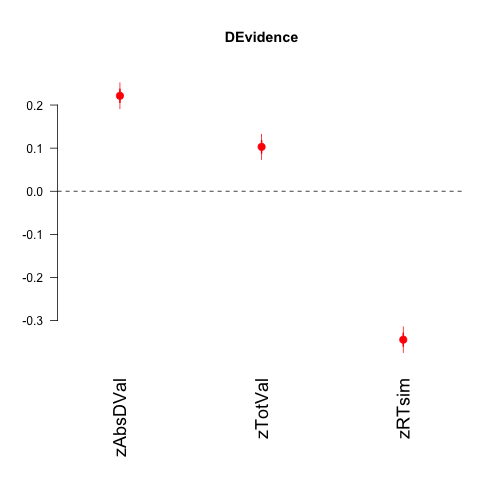

In [35]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

Looks like they replicate the result, even total value.

## From Smith 2018: we check some additional measures to check if they are fulfiled by the model , and also our data

While Smith 2018 observes the effect of TotVal at the level of RT we use confidence, but remember RT could be a proxy for confidence. I check for both frames

### <font color='Blue'> Like frame </font>

1. log(RT)~β1 +β2 |Ul −Ur| +β3 (Ul +Ur )  --> the multiplicative-model simulations displayed a negative relationship between RT and overall value (β2 = −0.013 s per rating, 95% confidence interval, or CI = [−0.014, −0.012], p < .001), whereas the additive- model simulations did not. Even when takin only DV = 0 trials.

BIC: 10272.02
Call:  glm(formula = zRTsim ~ zAbsDVal + zTotVal, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal  
 -0.0006151   -0.2444825   -0.1107436  

Degrees of Freedom: 3719 Total (i.e. Null);  3717 Residual
Null Deviance:	    3720 
Residual Deviance: 3415 	AIC: 10250


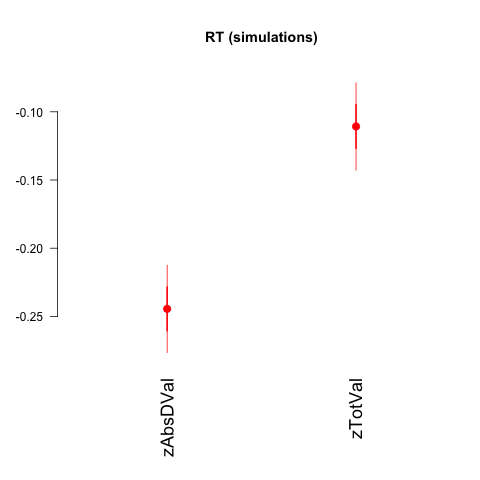

In [36]:
%%R    
title_plot = "RT (simulations)"
ModelChoice_1 <- glm(zRTsim ~ zAbsDVal + zTotVal  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

We observe a negative relationship between RT and Total Value. Altough, it should be considered that we are also including the attentional component given by the participants in this simulation.

BIC: 10081.68
Call:  glm(formula = zRT ~ zAbsDVal + zTotVal, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal  
   -0.08299     -0.13789      0.03573  

Degrees of Freedom: 3719 Total (i.e. Null);  3717 Residual
Null Deviance:	    3314 
Residual Deviance: 3245 	AIC: 10060


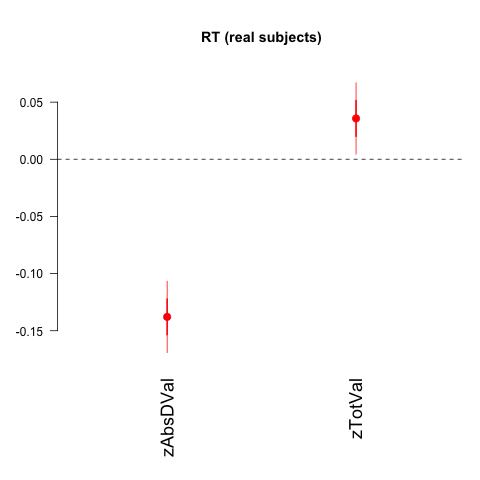

In [37]:
%%R    
title_plot = "RT (real subjects)"
ModelChoice_1 <- glm(zRT ~ zAbsDVal + zTotVal  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

Doesn't seem to replicate for the real subjects

Pearson's r = -0.156 p =  0.0


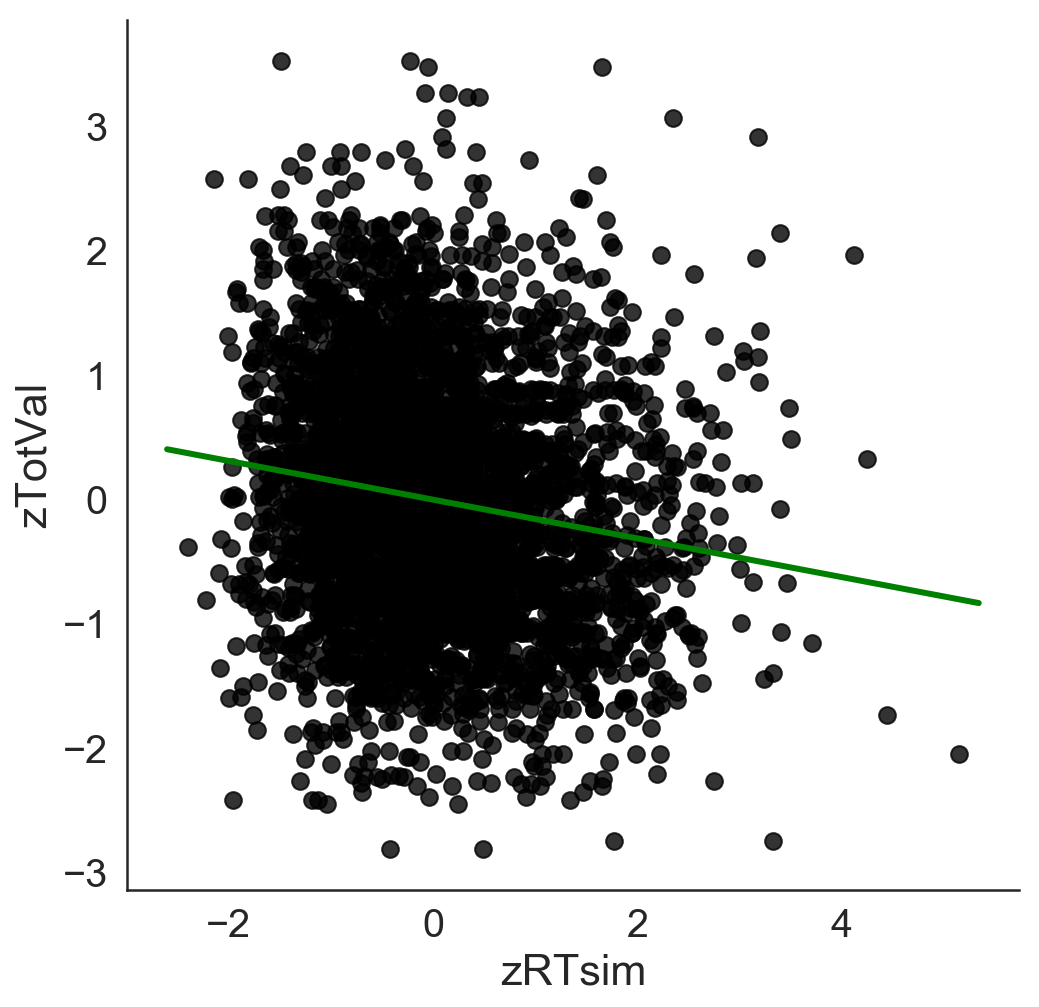

Pearson's r = 0.011 p =  0.512


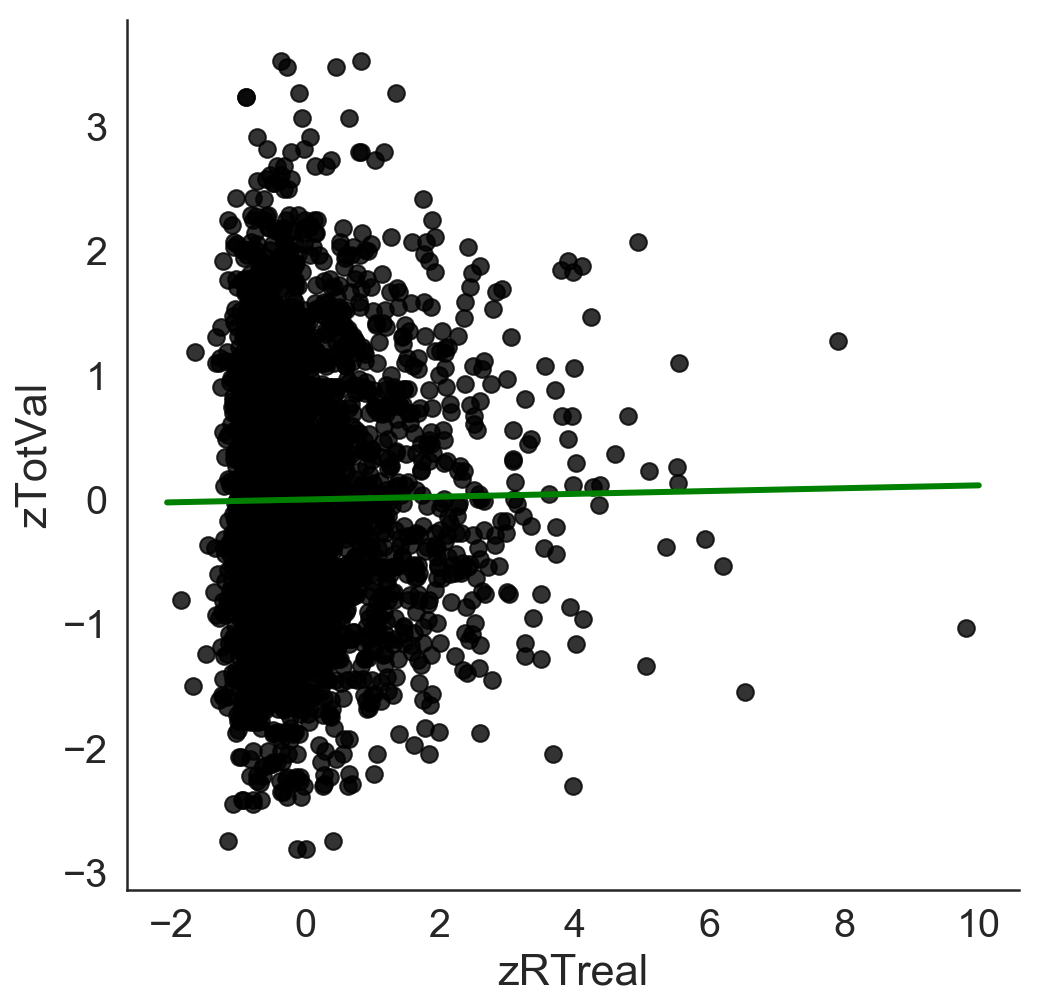

In [38]:
correl_plot(data_all,'zRTsim', "zRTsim",'zTotVal','zTotVal')
correl_plot(data_all,'zRT', "zRTreal",'zTotVal','zTotVal')

Higher overall value corresponds to shorter RTs only in the simulations

In [64]:
data_all["gaze_0"] =  data.gaze_0.values
data_all["gaze_1"] = data.gaze_1.values

zs1 = z_score1(data_all,'Part','gaze_0')
zs2 = z_score1(data_all,'Part','gaze_1')

data_all["zLGaze"] = zs1
data_all["zRGaze"] = zs2

In [65]:
data_all.head()

,Part,TrialN,PairID,LItem,LVal,RItem,RVal,Choice,RT,Conf,...,GSFSplit,DDTSplit,AbsDEv,RTsim,zAbsDEv,zRTsim,gaze_0,gaze_1,zLGaze,zRGaze
40,1,41,57,40_nestle_rolo.png,1.10,48_mentos_mint.png,0.95,0,2009,80,...,0,0,0.811912,3863.5,0.014584,2.300011,0.568396,0.431604,0.399816,-0.399816
41,1,42,41,11_lindt_orange.png,2.00,59_crunchie.png,1.70,0,3371,78,...,1,0,1.053243,2506.0,1.091475,-0.031052,0.762332,0.237668,2.127093,-2.127093
42,1,43,11,18_galaxy_bar.png,1.10,32_snickers.png,2.30,1,1700,82,...,0,1,1.030224,2606.5,0.988758,0.141524,0.446809,0.553191,-0.683098,0.683098
43,1,44,60,57_food_doctor_mild_korma_crisps.png,1.25,110_bombay_mix.png,1.40,1,7466,42,...,1,0,0.689093,3437.0,-0.533469,1.567636,0.532352,0.467648,0.078791,-0.078791
44,1,45,5,113_walkers_cheese.png,2.00,32_snickers.png,2.30,1,1889,70,...,0,1,0.615745,3535.0,-0.860773,1.735919,0.529736,0.470264,0.055494,-0.055494


In [66]:
%%R -i data_all
d1 <- data_all
#head(d1)

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


 
  .2. Second, we looked at the effect of gaze dwell time on choice for differently valued items and found that this effect generally increases with the value of the gazed-at item, particularly  for  the  food-choice  tasks.  

BIC: 4027.708
Call:  glm(formula = Choice ~ zDVal + zDDT + zDVal:zDDT, data = d1)

Coefficients:
(Intercept)        zDVal         zDDT   zDVal:zDDT  
   0.503225     0.203085     0.168036     0.003705  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    930 
Residual Deviance: 636 	AIC: 3997


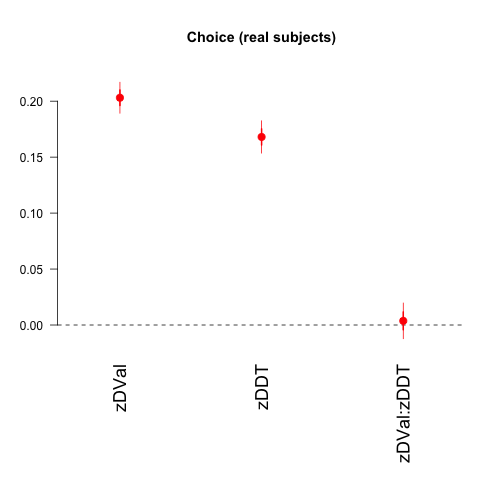

In [67]:
%%R    
title_plot = "Choice (real subjects)"
ModelChoice_1 <- glm(Choice ~ zDVal + zDDT +  zDVal:zDDT  , data= d1)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

No interaction between zDVal and zDDT appears in the real data (like in multiplicative model according to 

BIC: 3784.824
Call:  glm(formula = Choice ~ zLVal + zLGaze + zLVal:zLGaze, data = d1)

Coefficients:
 (Intercept)         zLVal        zLGaze  zLVal:zLGaze  
     0.49961      -0.11194      -0.25585      -0.00308  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    930 
Residual Deviance: 595.8 	AIC: 3754


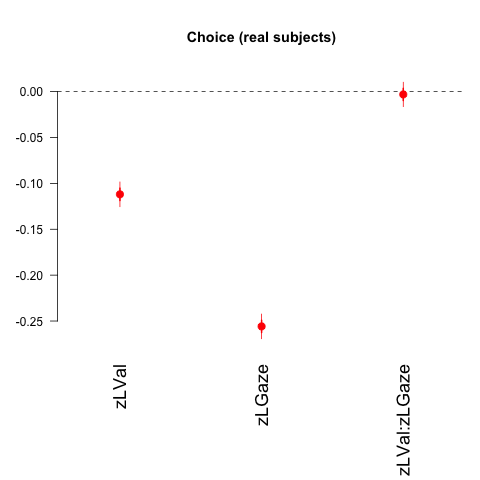

In [68]:
%%R    
title_plot = "Choice (real subjects)"
ModelChoice_1 <- glm(Choice ~ zLVal + zLGaze +  zLVal:zLGaze  , data= d1)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

### <font color='Red'> Dislike frame </font>


In [69]:
zs1 = z_score1(data_all2,'Part','AbsDEv')
zs2 = z_score1(data_all2,'Part','RTsim')

data_all2["zAbsDEv"] = zs1
data_all2["zRTsim"] = zs2

data_all2["gaze_0"] =  data2.gaze_0.values
data_all2["gaze_1"] = data2.gaze_1.values

zs1 = z_score1(data_all2,'Part','gaze_0')
zs2 = z_score1(data_all2,'Part','gaze_1')

data_all2["zLGaze"] = zs1
data_all2["zRGaze"] = zs2

In [70]:
%%R -i data_all2
d2 <- data_all2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


1. log(RT)~β1 +β2 |Ul −Ur| +β3 (Ul +Ur )  --> the multiplicative-model simulations displayed a negative relationship between RT and overall value (β2 = −0.013 s per rating, 95% confidence interval, or CI = [−0.014, −0.012], p < .001), whereas the additive- model simulations did not. Even when takin only DV = 0 trials.

BIC: 10454.21
Call:  glm(formula = zRTsim ~ zAbsDVal + zTotVal, data = d2)

Coefficients:
(Intercept)     zAbsDVal      zTotVal  
  0.0001314   -0.1753521    0.1110904  

Degrees of Freedom: 3719 Total (i.e. Null);  3717 Residual
Null Deviance:	    3720 
Residual Deviance: 3587 	AIC: 10430


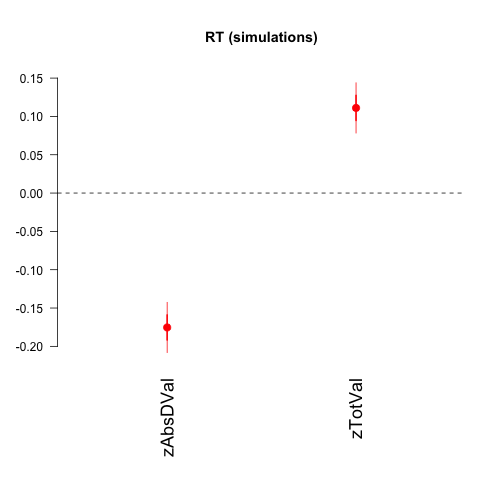

In [71]:
%%R    
title_plot = "RT (simulations)"
ModelChoice_1 <- glm(zRTsim ~ zAbsDVal + zTotVal  , data= d2)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

We observe a negative relationship between RT and Total Value. Altough, it should be considered that we are also including the attentional component given by the participants in this simulation.

BIC: 10812.89
Call:  glm(formula = zRT ~ zAbsDVal + zTotVal, data = d2)

Coefficients:
(Intercept)     zAbsDVal      zTotVal  
    0.08286     -0.15528      0.13152  

Degrees of Freedom: 3719 Total (i.e. Null);  3717 Residual
Null Deviance:	    4075 
Residual Deviance: 3950 	AIC: 10790


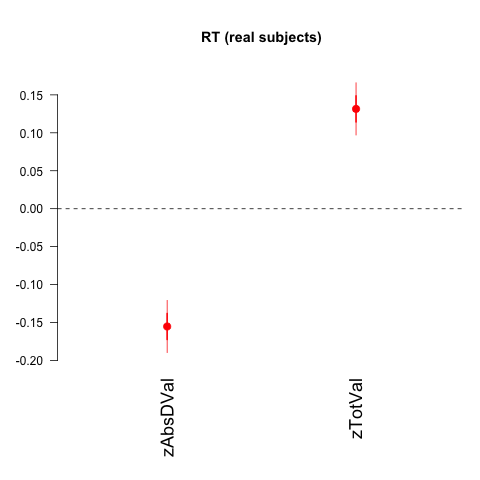

In [72]:
%%R    
title_plot = "RT (real subjects)"
ModelChoice_1 <- glm(zRT ~ zAbsDVal + zTotVal  , data= d2)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

Doesn't seem to replicate for the real subjects

Pearson's r = 0.078 p =  0.0


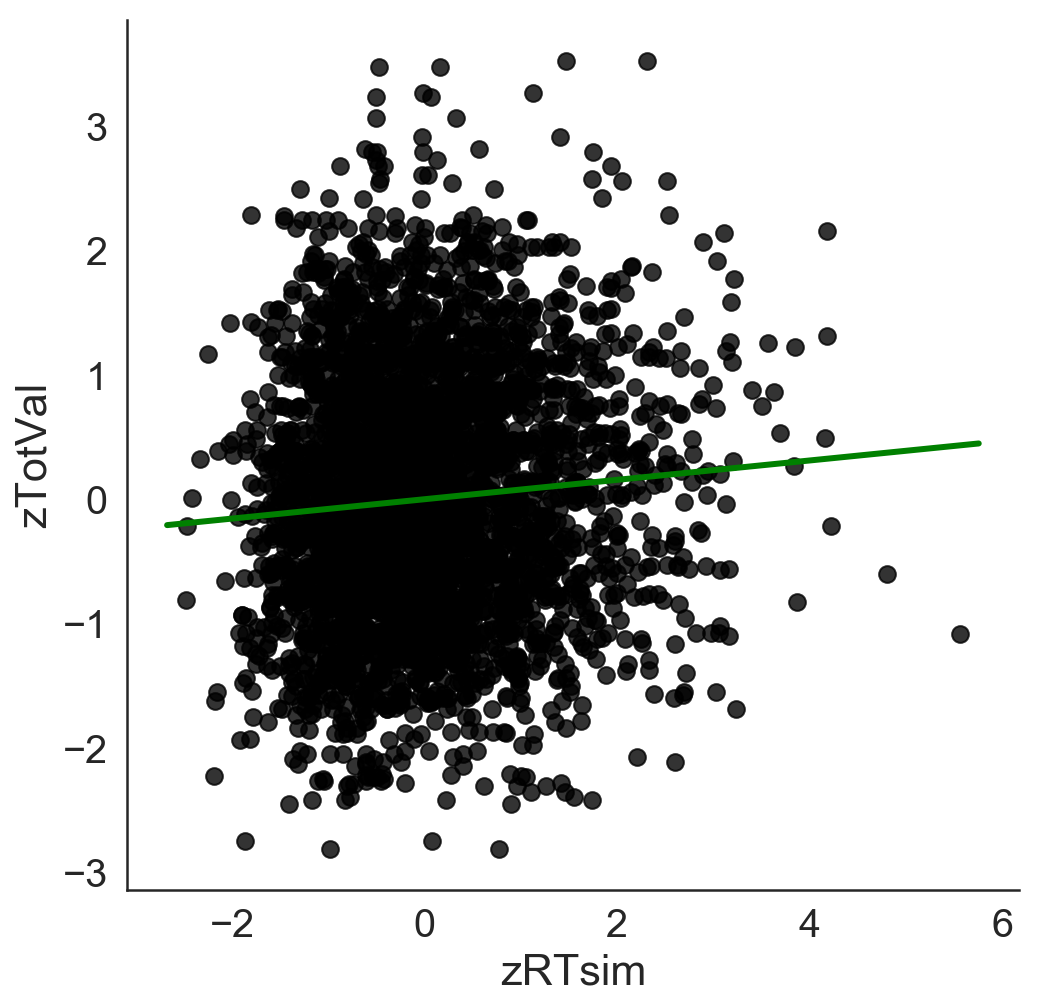

Pearson's r = 0.098 p =  0.0


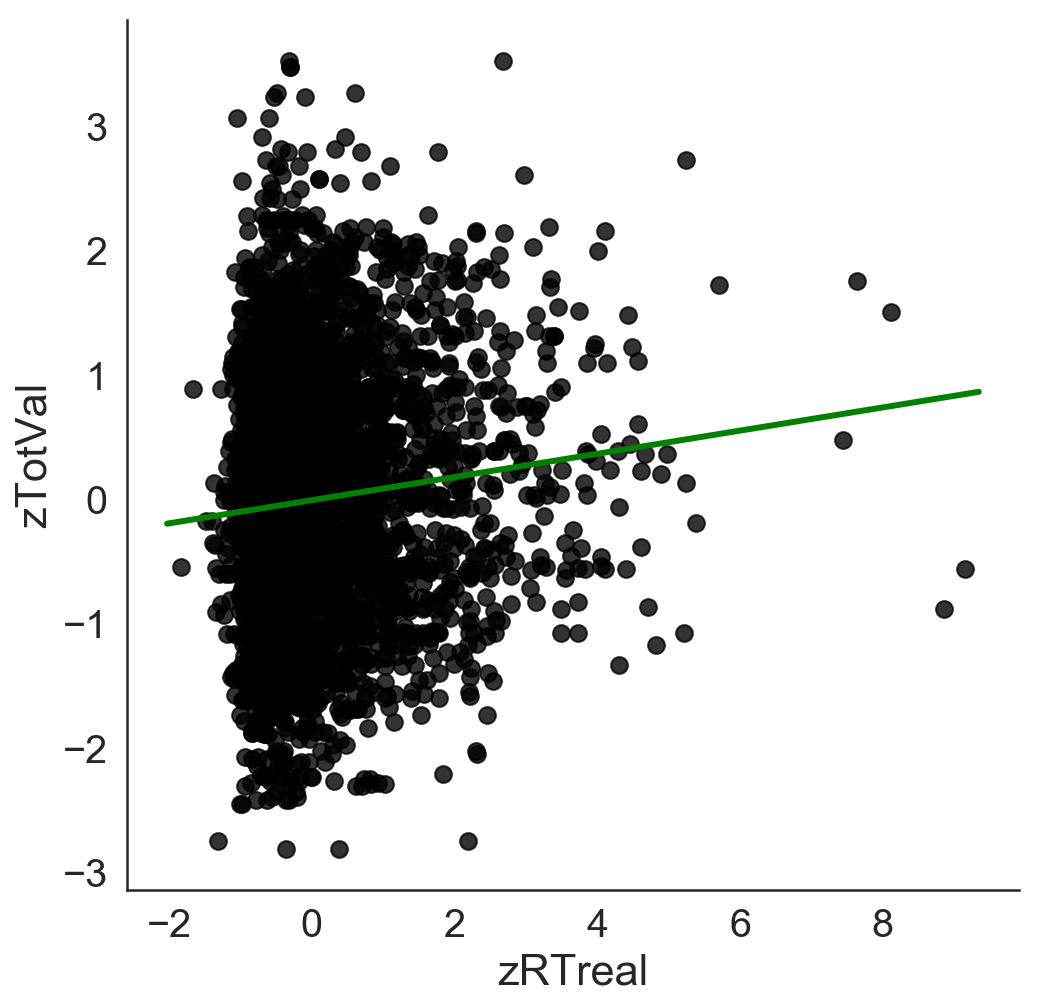

In [73]:
correl_plot(data_all2,'zRTsim', "zRTsim",'zTotVal','zTotVal')
correl_plot(data_all2,'zRT', "zRTreal",'zTotVal','zTotVal')

Higher overall value corresponds to shorter RTs only in the simulations

In [74]:
%%R -i data_all2
d2 <- data_all2
#head(d1)

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


 
  .2. Second, we looked at the effect of gaze dwell time on choice for differently valued items and found that this effect generally increases with the value of the gazed-at item, particularly  for  the  food-choice  tasks.  

BIC: 4284.724
Call:  glm(formula = Choice ~ zDVal + zDDT + zDVal:zDDT, data = d2)

Coefficients:
(Intercept)        zDVal         zDDT   zDVal:zDDT  
  0.4987301   -0.1902411    0.1470535    0.0007398  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    930 
Residual Deviance: 681.5 	AIC: 4254


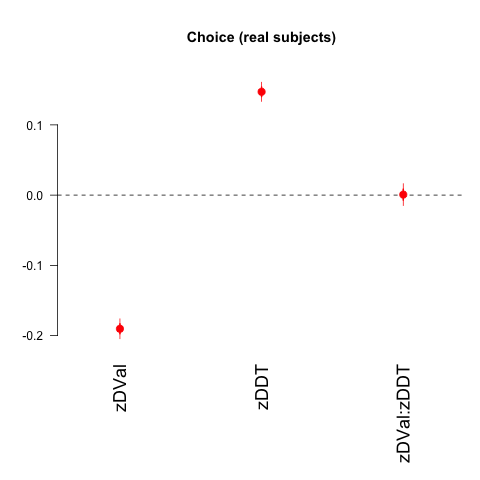

In [75]:
%%R    
title_plot = "Choice (real subjects)"
ModelChoice_1 <- glm(Choice ~ zDVal + zDDT +  zDVal:zDDT  , data= d2)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

No interaction between zDVal and zDDT appears in the real data (like in multiplicative model according to 

BIC: 3986.787
Call:  glm(formula = Choice ~ zLVal + zLGaze + zLVal:zLGaze, data = d2)

Coefficients:
 (Intercept)         zLVal        zLGaze  zLVal:zLGaze  
    0.501671      0.110661     -0.245466     -0.003395  

Degrees of Freedom: 3719 Total (i.e. Null);  3716 Residual
Null Deviance:	    930 
Residual Deviance: 629.1 	AIC: 3956


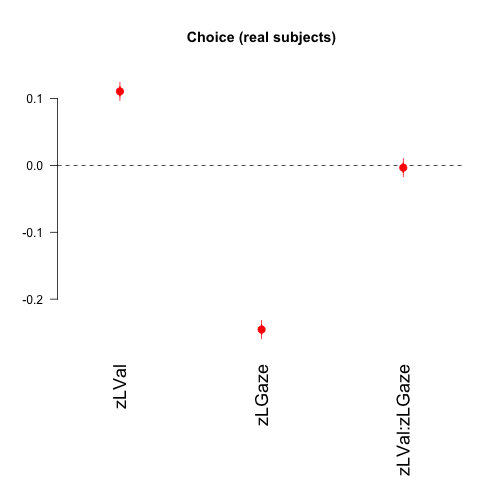

In [76]:
%%R    
title_plot = "Choice (real subjects)"
ModelChoice_1 <- glm(Choice ~ zLVal + zLGaze +  zLVal:zLGaze  , data= d2)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# Check special cases in which Total Value is the same, but internal value of individual items varies

In [75]:
data_cmp = data_all
data_cmp['LValBin'] = data['item_value_0']
data_cmp['RValBin'] = data['item_value_1']
data_cmp['LGaze'] = data['gaze_0']
data_cmp['RGaze'] = data['gaze_1']

In [76]:
## Case when  TotVal = 5, LVal = 0 , RVal = 5

data_tot1 = data_cmp.loc[((data_cmp['LValBin'] == 5) & (data_cmp['RValBin'] == 0)) | ((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 5)) | ((data_cmp['LValBin'] == 4) & (data_cmp['RValBin'] == 0)) | ((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 4)) | ((data_cmp['LValBin'] == 3) & (data_cmp['RValBin'] == 0)) | ((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 3)) | ((data_cmp['LValBin'] == 2) & (data_cmp['RValBin'] == 0)) | ((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 2)) | ((data_cmp['LValBin'] == 1) & (data_cmp['RValBin'] == 0)) | ((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 1))]
data_tot2 = data_cmp.loc[((data_cmp['LValBin'] == 0) & (data_cmp['RValBin'] == 0)) |((data_cmp['LValBin'] == 1) & (data_cmp['RValBin'] == 1)) | ((data_cmp['LValBin'] == 2) & (data_cmp['RValBin'] == 2)) | ((data_cmp['LValBin'] == 3) & (data_cmp['RValBin'] == 3))|((data_cmp['LValBin'] == 4) & (data_cmp['RValBin'] == 4)) | ((data_cmp['LValBin'] == 5) & (data_cmp['RValBin'] == 5))]


BIC1 :  2367.491 BIC2 :  2663.946
TotVal Equal : TotVal = 5 , LVal or Rval = 5 , RVal or LVal = 0
TotVal Diff : TotVal = 5 , LVal or Rval = 2 , RVal or LVal = 3

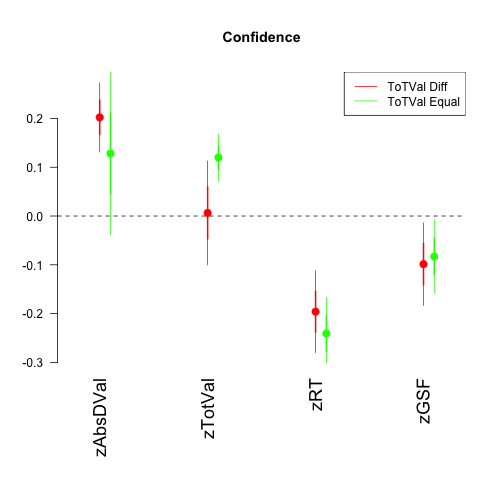

In [77]:
%%R -i data_tot1 -i data_tot2
d1 <- data_tot1
title_plot = "Confidence"
ModelConf_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT + zGSF  , data= d1)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
BIC1Conf = BIC(ModelConf_1)
cat("BIC1 : " , BIC1Conf)
ModelConf_1

d2 <- data_tot2
title_plot = "Confidence"
ModelConf_2 <- glm(zConf ~ zAbsDVal + zTotVal + zRT + + zGSF  , data= d2)
coefplot(ModelConf_2,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="green", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
BIC2Conf = BIC(ModelConf_2)
cat(" BIC2 : " , BIC2Conf)
ModelConf_2

legend("topright",  legend=c("ToTVal Diff", "ToTVal Equal"),col=c("red", "green"), lty=1:1, cex=1)

cat('\nTotVal Equal : TotVal = 5 , LVal or Rval = 5 , RVal or LVal = 0')
cat('\nTotVal Diff : TotVal = 5 , LVal or Rval = 2 , RVal or LVal = 3')


Seems to be that TotVal doesn't have an effect when in TotVal one of the items carry the entire value of the pair (in that case it's kind of redundant with AbsDVal). It is informative when both items have similar values.

BIC1 :  2392.615 BIC2 :  2648.9
TotVal Equal : TotVal = 5 , LVal or Rval = 5 , RVal or LVal = 0
TotVal Diff : TotVal = 5 , LVal or Rval = 2 , RVal or LVal = 3

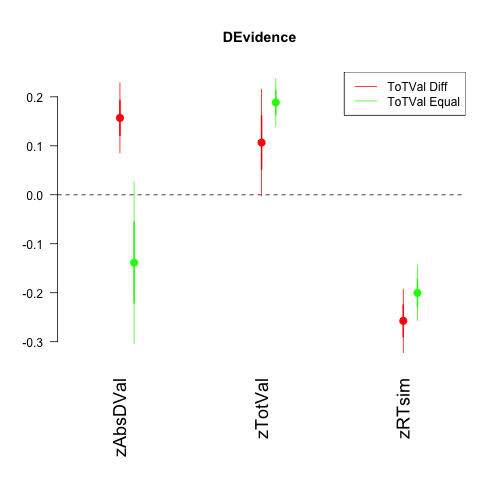

In [78]:
%%R -i data_tot1 -i data_tot2
d1 <- data_tot1
title_plot = "DEvidence "
ModelConf_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d1)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
BIC1Conf = BIC(ModelConf_1)
cat("BIC1 : " , BIC1Conf)
ModelConf_1

d2 <- data_tot2
title_plot = "DEvidence "
ModelConf_2 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d2)
coefplot(ModelConf_2,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="green", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
BIC2Conf = BIC(ModelConf_2)
cat(" BIC2 : " , BIC2Conf)
ModelConf_2

legend("topright",  legend=c("ToTVal Diff", "ToTVal Equal"),col=c("red", "green"), lty=1:1, cex=1)

cat('\nTotVal Equal : TotVal = 5 , LVal or Rval = 5 , RVal or LVal = 0')
cat('\nTotVal Diff : TotVal = 5 , LVal or Rval = 2 , RVal or LVal = 3')


BIC1 :  2909.976
 Equal value for item pairs, DV = 0

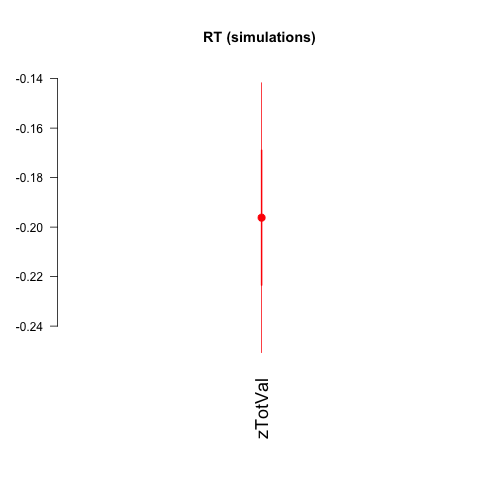

In [84]:
%%R -i data_tot2
d2 <- data_tot2
title_plot = "RT (simulations) "
ModelConf_1 <- glm(zRTsim ~ zTotVal  , data= d2)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
BIC1Conf = BIC(ModelConf_1)
cat("BIC1 : " , BIC1Conf)
ModelConf_1

cat('\n Equal value for item pairs, DV = 0' )



# 4. Simulations for correct / incorrect

## Load data and GLAM structure 
Used binned data for simulation.

In [14]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

#data2 = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Dislike_NoBin_Inv_31.csv'))
## Subset only necessary columns
#data2 = data2[['subject', 'trial', 'choice', 'rt',
#         'item_value_0', 'item_value_1',
#         'gaze_0', 'gaze_1']]

In [15]:
# Load data for FF2018 study 

# Like condition 

data_all0 = pd.read_csv('data/FF2018_data/DataFoodFramingNotebook_31.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)
data_all = data_all0.loc[data_all0['BlockCond'] == 1] # 1 = Like, 2 = Dislike

data_all=data_all.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

# Dislike condition

#data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # 1 = Like, 2 = Dislike

#data_all2=data_all2.rename(index=str, columns={"ChosenITM":"Choice", 
#                              "ChoiceRT":"RT",
#                             "RValue":"RVal",
#                             "LValue":"LVal",
#                             "zRValue":"zRVal",
#                             "zLValue":"zLVal",                    
#                             "tDDT":"DDT",
#                             "absDDT":"zAbsDDT",
#                             "lIA_DT":"LDwellTime",
#                             "rIA_DT":"RDwellTime",
#                             "tGSF":"GSF",
#                             "lastFixat":"LastFixat",
#                            "DV":"DVal",
#                            "zDV":"zDVal",
#                            "absDV":"AbsDVal",
 #                            "zAbsDV":"zAbsDVal",                    
 #                            "zChoiceRT":"zRT",
 #                            "FamCh":"ChosenFam",
 #                             "FamUnCh":"UnchosenFam",
 #                             "ValCh":"ChosenVal",
 #                             "ValUnCh":"UnchosenVal",
 #                            "zFamCh":"zChosenFam",
 #                             "zFamUnCh":"zUnchosenFam",
 #                             "zValCh":"zChosenVal",
 #                             "zValUnCh":"zUnchosenVal",                   
 #                             "GSFMedSplit":"GSFSplit",
 #                           "DDTMedSplit":"DDTSplit"})

## Load parameter estimates for participants

## Like condition

Use the parameter estimates from GLAM fit for Like, Binned data. Median values

In [16]:
sufix = '_Like_NoBin_NUTS_31'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))
glam_full.estimates = pd.DataFrame.from_dict(glam_full.estimates.item(0))
params_part = glam_full.estimates

In [17]:
params_part

,v_sd,v_mu,gamma_mu,tau_mu,t0,b,tau_sd,SNR,p_error,tau,gamma_sd,gamma,SNR_sd,v,s,SNR_mu
0,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,151.23,0.05,3.74,0.38,-0.11,35.54,0.000047,0.007843,164.29
1,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.71,0.05,4.30,0.38,0.29,35.54,0.000072,0.010344,164.29
2,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,141.48,0.05,2.59,0.38,-0.00,35.54,0.000058,0.008574,164.29
3,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,157.60,0.05,4.65,0.38,-0.10,35.54,0.000043,0.007178,164.29
4,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,96.58,0.05,4.22,0.38,-0.37,35.54,0.000080,0.007063,164.29
5,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,113.65,0.05,2.80,0.38,0.15,35.54,0.000059,0.008615,164.29
6,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,163.65,0.05,3.55,0.38,-0.00,35.54,0.000069,0.010656,164.29
7,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,150.49,0.05,3.29,0.38,-0.08,35.54,0.000045,0.007405,164.29
8,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,175.26,0.05,1.24,0.38,-0.71,35.54,0.000053,0.009622,164.29
9,0.000013,0.000052,-0.26,3.34,0.0,1.0,1.14,137.66,0.05,4.77,0.38,-0.08,35.54,0.000048,0.007104,164.29


### Run drift simulations for selected values and parameters

In [22]:
if os.path.exists(str('results/simulations/drift_simulations_RT_Choices_like_31_part.csv')):  
   
        data_simulation = pd.read_csv("results/simulations/drift_simulations_RT_Choices_like_31_part.csv")


In [23]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 #Repeat outside the accumulator function

In [20]:
if not os.path.exists(str('results/simulations/drift_simulations_RT_Choices_like_31_part.csv')):  
 
    LVal = []
    RVal = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    
    for i in (data['subject'].unique()):    
        for k in range(0,repeat_extra) :
            PartData = data.loc[data['subject'] == i]
            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            
            # We keep the same parameters for this case. 
            gamma = params_part['gamma'].median()
            tau = params_part['tau'].median()
            v = params_part['v'].median()
            s = params_part['s'].median()
            t0 = 0
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            for  j in range(len(Dev_a)):
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

In [21]:
data_simulation =  pd.DataFrame()
data_simulation["LVal"] = LVal
data_simulation["RVal"] = RVal
data_simulation["AbsDVal"] = absDVal
data_simulation["TotVal"] = TotVal
data_simulation["AbsDEv"] = AbsDEvid
data_simulation["RTsim"] = RT_sim
data_simulation["Correct_sim"] = Correct_sim
data_simulation["Choice_sim"] = Choice_sim

NameError: name 'LVal' is not defined

In [105]:
data_simulation["zLVal"] = z_score1_nopart(data_simulation,"LVal")
data_simulation["zRVal"] = z_score1_nopart(data_simulation,"RVal")
data_simulation["zAbsDVal"] = z_score1_nopart(data_simulation,"AbsDVal")
data_simulation["zTotVal"] = z_score1_nopart(data_simulation,"TotVal")
data_simulation["zAbsDEv"] = z_score1_nopart(data_simulation,"AbsDEv")
data_simulation["zRTsim"] = z_score1_nopart(data_simulation,"RTsim")
data_simulation["zCorrect_sim"] = z_score1_nopart(data_simulation,"Correct_sim")
data_simulation["zChoice_sim"] = z_score1_nopart(data_simulation,"Choice_sim")


In [106]:
data_simulation.head()

,LVal,RVal,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim,zCorrect_sim,zChoice_sim
0,0.0,0.0,0.0,0.0,0.427745,4863.0,0,0.0,-1.466950,-1.461476,-1.190241,-2.071377,-1.025210,2.621883,-1.694505,-0.999243
1,5.0,4.0,1.0,9.0,0.940050,1580.0,1,0.0,1.546393,0.947199,-0.528253,1.763630,0.303774,-0.826285,0.590143,-0.999243
2,0.0,5.0,5.0,5.0,1.831134,1862.0,1,1.0,-1.466950,1.549368,2.119700,0.059182,2.615352,-0.530097,0.590143,1.000758
3,1.0,2.0,1.0,3.0,0.421067,3016.0,1,1.0,-0.864282,-0.257138,-0.528253,-0.793042,-1.042533,0.681960,0.590143,1.000758
4,5.0,5.0,0.0,10.0,0.687349,3185.0,0,1.0,1.546393,1.549368,-1.190241,2.189742,-0.351764,0.859463,-1.694505,1.000758


In [2]:
# Number of trials simulated
len (data_simulation)

NameError: name 'data_simulation' is not defined

In [107]:
if not  os.path.exists(str('results/simulations/drift_simulations__RT_Choices_like_31_part.csv')):  
    
        data_simulation.to_csv("results/simulations/drift_simulations_RT_Choices_like_31_part.csv")

In [26]:
data_simulation = data_all
len(data_simulation)

39600

In [108]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

In [109]:
%R -i data_simulation 

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [110]:
%%R 
data_exp1_Like <- data_simulation

[1] "Like BIC:"
[1] 107510.6


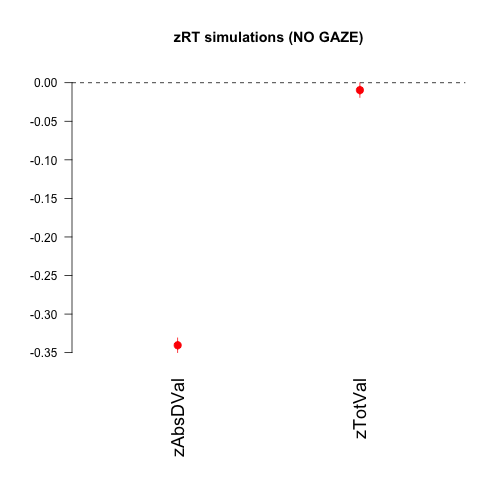

In [111]:
%%R
title_plot = ("zRT simulations (NO GAZE)")
Model <- glm(zRTsim ~ zAbsDVal + zTotVal , data=data_exp1_Like)

BIC1 = BIC(Model)
print("Like BIC:")
print(BIC1)

coefplot(Model,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,5,5,1), main=title_plot)


[1] "Like BIC:"
[1] 106217


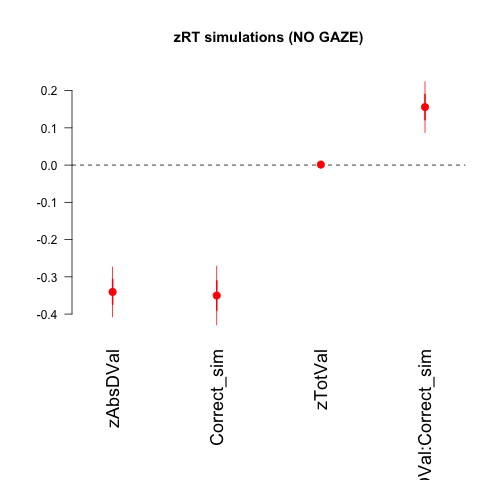

In [114]:
%%R

title_plot = ("zRT simulations (NO GAZE)")

Model <- glm(zRTsim ~ zAbsDVal + Correct_sim + zTotVal + zAbsDVal : Correct_sim , data=data_exp1_Like)

BIC1 = BIC(ModelChoiceL_Fam2)
print("Like BIC:")
print(BIC1)
coefplot(Model,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,5,5,1),  main=title_plot)


## [END]